In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 2


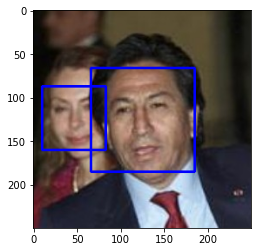

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

# load color (BGR) image
img = cv2.imread(human_files[288])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):    
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


## Test the performance of the face_detector algorithm on the images in human_files_short and dog_files_short.
Nb_human_face_detected = sum([face_detector(path) for path in human_files_short])
Nb_dog_face_detected= sum([face_detector(path) for path in dog_files_short])

# Print out results
print('Percentage of human_faces detected in the first 100 human_files_short: {}%'.
      format(100*int(Nb_human_face_detected / 100)))
print('Percentage of faces detected in dog_files_short: {}%'.format(int(100*Nb_dog_face_detected / 100)))

Percentage of human_faces detected in the first 100 human_files_short: 100%
Percentage of faces detected in dog_files_short: 54%


In [6]:
import os
print(os.listdir('haarcascades'))

['haarcascade_frontalcatface_extended.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_frontalface_alt_tree.xml', 'haarcascade_frontalface_default.xml', 'RE']


In [7]:
img_folder = 'haarcascades' + '/haarcascade_frontalface_default.xml'
cv2.CascadeClassifier(img_folder)

<CascadeClassifier 000001BDA90FF230>

In [8]:
## (Optional) TODO: Report the performance of another face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

def face_detector2(img_path, xml_file = 'haarcascade_frontalface_default.xml'):  
    # Here I try another haarcascades classifier from opencv
    # In this case -> haarcascade_frontalface_alt_tree.xml
    
    face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml') 

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

Nb_human_face_detected = sum([face_detector2(path) for path in human_files_short])
Nb_dog_face_detected= sum([face_detector2(path) for path in dog_files_short])
print('Percentage of human_faces detected in the first 100 human_files_short: {}%'.
      format(100*int(Nb_human_face_detected / 100)))
print('Percentage of faces detected in dog_files_short: {}%'.format(int(100*Nb_dog_face_detected / 100)))

Percentage of human_faces detected in the first 100 human_files_short: 100%
Percentage of faces detected in dog_files_short: 19%


In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights = 'imagenet')

In [10]:
from tensorflow.keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size = (224, 224))
    
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):    
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    
    return np.vstack(list_of_tensors)

In [11]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    
    return np.argmax(ResNet50_model.predict(img))

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    
    return ((prediction <= 268) & (prediction >= 151)) 

1/1 [==============================] - 0s 139ms/step


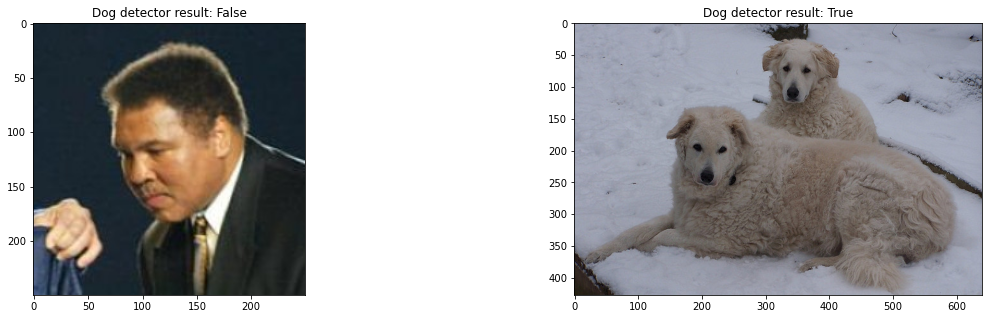

In [13]:
files = [human_files_short[0], dog_files_short[0]]
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))
for idx, file in enumerate(files):
    load_img = cv2.imread(file)
    rgb_img = cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)
    ax[idx].imshow(rgb_img)
    ax[idx].set_title('Dog detector result: ' + str(dog_detector(file)))

In [14]:
### TODO: Test the performance of the dog_detector function on the images in human_files_short and dog_files_short.

Nb_human_face_detected = sum([dog_detector(path) for path in human_files_short])
Nb_dog_face_detected= sum([dog_detector(path) for path in dog_files_short])

print('Percentage of dogs detected in the first 100 human_files_short: {}%'.
      format(100*int(Nb_human_face_detected / 100)))
print('Percentage of dogs detected in dog_files_short: {}%'.
      format(int(100*Nb_dog_face_detected / 100)))

1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 99ms/step
Percentage of dogs detected in the first 100 human_files_short: 0%
Percentage of dogs detected in dog_files_short: 100%


In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

In [16]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 101.25it/s]


In [17]:
print(test_tensors.shape)

(836, 224, 224, 3)


In [18]:
### TODO: Define your architecture.
model.add(Conv2D(16, kernel_size = 2, strides = (1, 1),
                 input_shape = (224, 224, 3),
                 activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2, 2), padding = 'valid'))
model.add(Conv2D(32, kernel_size = 2, 
                 strides = (1, 1), activation = 'sigmoid'))
model.add(MaxPooling2D(pool_size = 2, strides = (2, 2), padding = 'same'))
model.add(Conv2D(64, kernel_size = 2, 
                 strides = (1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2, strides = (2, 2), padding = 'same'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.25))
model.add(Dense(133, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 64)       0

In [19]:
model.compile(optimizer = 'rmsprop', 
              loss = 'categorical_crossentropy', 
              metrics=['accuracy'])

In [20]:
from keras.preprocessing.image import ImageDataGenerator

img_gen_train = ImageDataGenerator(
                        fill_mode = 'constant',  
                        width_shift_range = 0.15,  # randomly shift images horizontally (15% of total width)
                        height_shift_range = 0.15,  # randomly shift images vertically (15% of total height)
                        horizontal_flip = True) # randomly flip images horizontally

img_gen_valid = ImageDataGenerator(
                        fill_mode = 'constant', 
                        width_shift_range = 0.15,  # randomly shift images horizontally (15% of total width)
                        height_shift_range = 0.15,  # randomly shift images vertically (15% of total height)
                        horizontal_flip = True) # randomly flip images horizontally

img_gen_train

In [21]:
img_gen_train.fit(train_tensors)
img_gen_valid.fit(valid_tensors)

In [22]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
epochs = 3
batch_size = 64 # I have tried 16, 32 before but not good

checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.from_scratch.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

history = model.fit_generator(
                    img_gen_train.flow(train_tensors, train_targets,        # training data (X, y, batchsize)
                                       batch_size = batch_size),
                    steps_per_epoch = train_tensors.shape[0] // batch_size, # Total number of steps (batches of samples) before declaring 
                                                                            # one epoch finished and starting the next epoch. 
                    epochs = epochs, # Number of samples per gradient update.
                    verbose = 1,     # Verbosity mode
                    callbacks = [checkpointer],
                    validation_data = img_gen_valid.flow(valid_tensors, valid_targets,# Data on which to evaluate the loss and any model metrics 
                                                                                    # at the end of each epoch. 
                                                         batch_size = batch_size), # The model will not be trained on this data.
                    validation_steps = valid_tensors.shape[0] // batch_size  #  Total number of steps (batches of samples) to draw before 
                                                                             # stopping when performing validation at the end of every epoch.
                   )

<ipython-input-22-71c6c297b560>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/3
104/104 [==============================] - ETA: 0s - loss: 4.8944 - accuracy: 0.0065
Epoch 1: val_loss improved from inf to 4.88493, saving model to saved_models\weights.best.from_scratch.hdf5
104/104 [==============================] - 177s 2s/step - loss: 4.8944 - accuracy: 0.0065 - val_loss: 4.8849 - val_accuracy: 0.0108
Epoch 2/3
104/104 [==============================] - ETA: 0s - loss: 4.8841 - accuracy: 0.0089
Epoch 2: val_loss improved from 4.88493 to 4.88037, saving model to saved_models\weights.best.from_scratch.hdf5
104/104 [==============================] - 164s 2s/step - loss: 4.8841 - accuracy: 0.0089 - val_loss: 4.8804 - val_accuracy: 0.0096
Epoch 3/3
104/104 [==============================] - ETA: 0s - loss: 4.8791 - accuracy: 0.0095
Epoch 3: val_loss improved from 4.88037 to 4.87685, saving model to saved_models\weights.best.from_scratch.hdf5
104/104 [==============================] - 169s 2s/step - loss: 4.8791 - accuracy: 0.0095 - val_loss: 4.8769 - val_accu

In [23]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [24]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
Test accuracy: 1.0766%


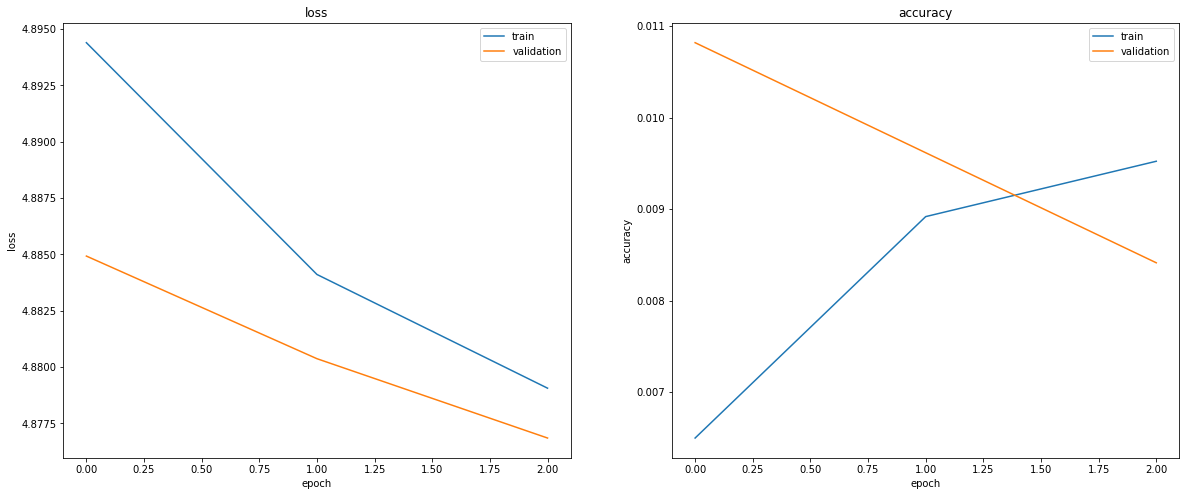

In [25]:
def display_model_acc_loss(model_history = history, loc = 'best', figsize = (20, 8)):
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = figsize)
    plot_types = ['loss', 'accuracy']
    titles = ['loss', 'accuracy']
    for k in range(2):
        ax[k].plot(model_history.history[plot_types[k]])
        ax[k].plot(model_history.history['val_' + plot_types[k]])
        ax[k].set_ylabel(titles[k])
        ax[k].set_xlabel('epoch')
        ax[k].legend(['train', 'validation'], loc = loc)
        ax[k].set_title(titles[k])
    plt.show()
    
display_model_acc_loss(history)

In [26]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [27]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
# But here, i want to check what will happen if adding the drop-out
VGG16_model.add(Dropout(0.1))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 133)               68229     
                                                                 
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [28]:
VGG16_model.compile(loss = 'categorical_crossentropy', 
                    optimizer = 'rmsprop',
                    metrics = ['accuracy'])

In [29]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose = 1, save_best_only = True)

VGG16_history = VGG16_model.fit(train_VGG16, train_targets, 
                                validation_data=(valid_VGG16, valid_targets),
                                epochs = 20, batch_size = 32, 
                                callbacks=[checkpointer], verbose = 1)

Epoch 1/20
198/209 [===========================>..] - ETA: 0s - loss: 10.3174 - accuracy: 0.1548
Epoch 1: val_loss improved from inf to 4.05995, saving model to saved_models\weights.best.VGG16.hdf5
209/209 [==============================] - 3s 10ms/step - loss: 10.0698 - accuracy: 0.1639 - val_loss: 4.0599 - val_accuracy: 0.4144
Epoch 2/20
200/209 [===========================>..] - ETA: 0s - loss: 3.4150 - accuracy: 0.4845
Epoch 2: val_loss improved from 4.05995 to 2.72611, saving model to saved_models\weights.best.VGG16.hdf5
209/209 [==============================] - 1s 4ms/step - loss: 3.3939 - accuracy: 0.4871 - val_loss: 2.7261 - val_accuracy: 0.5725
Epoch 3/20
202/209 [===========================>..] - ETA: 0s - loss: 2.0621 - accuracy: 0.6292
Epoch 3: val_loss improved from 2.72611 to 2.27397, saving model to saved_models\weights.best.VGG16.hdf5
209/209 [==============================] - 1s 5ms/step - loss: 2.0477 - accuracy: 0.6313 - val_loss: 2.2740 - val_accuracy: 0.6251
Epoch

In [30]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

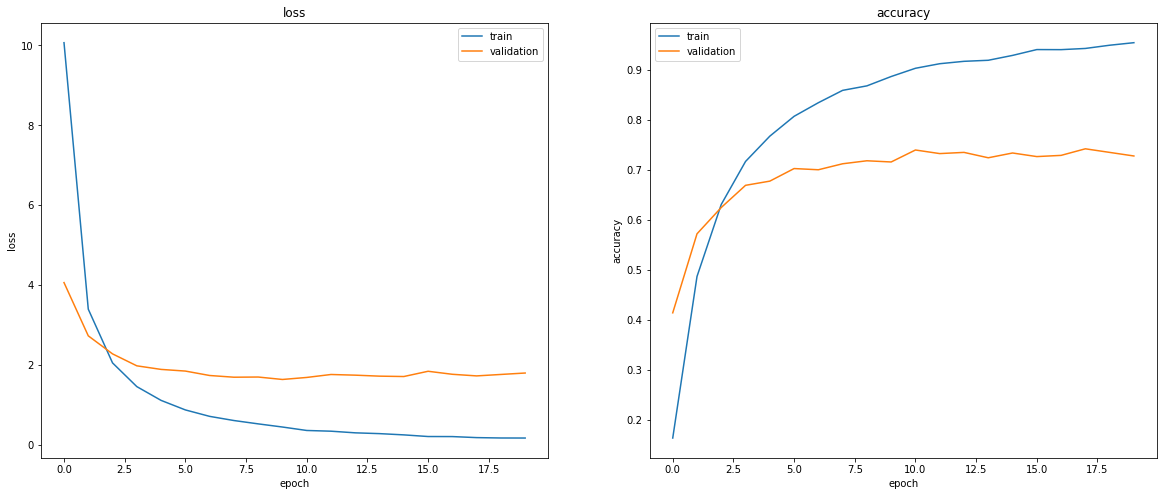

Wall time: 665 ms


In [31]:
%time display_model_acc_loss(VGG16_history)

In [32]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis = 0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis = 1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Test accuracy: 73.2057%


In [33]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [34]:
os.listdir('bottleneck_features')

['.gitignore', 'DogResnet50Data.npz', 'DogVGG16Data.npz']

In [35]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_res50net = bottleneck_features['train']
valid_res50net = bottleneck_features['valid']
test_res50net = bottleneck_features['test']

In [36]:
### TODO: Define your architecture.
res50net_model = Sequential()
res50net_model.add(GlobalAveragePooling2D(input_shape = train_res50net.shape[1:]))
res50net_model.add(Dense(512, activation='relu'))
res50net_model.add(Dropout(0.2))
res50net_model.add(Dense(133, activation='softmax'))

# <your model's name>.summary()
res50net_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 133)               68229     
                                                                 
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________


In [37]:
### TODO: Compile the model.
from keras.optimizers import SGD

res50net_model.compile(loss = 'categorical_crossentropy', 
                       optimizer = SGD(lr = 0.001), metrics = ['accuracy'])

C:\Users\admin\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [38]:
### TODO: Train the model.
from keras.preprocessing.image import ImageDataGenerator

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose = 2, save_best_only = True)

resnet50_history = res50net_model.fit(train_res50net, train_targets, 
                                      validation_data = (valid_res50net, valid_targets),
                                      epochs = 100, batch_size = 64,
                                      callbacks=[checkpointer], verbose = 0)


Epoch 1: val_loss improved from inf to 4.97869, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 2: val_loss improved from 4.97869 to 4.77633, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 3: val_loss improved from 4.77633 to 4.61313, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 4: val_loss improved from 4.61313 to 4.46667, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 5: val_loss improved from 4.46667 to 4.32751, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 6: val_loss improved from 4.32751 to 4.19098, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 7: val_loss improved from 4.19098 to 4.05402, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 8: val_loss improved from 4.05402 to 3.91605, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 9: val_loss improved from 3.91605 to 3.77478, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 10: val_loss imp


Epoch 76: val_loss improved from 0.86152 to 0.85561, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 77: val_loss improved from 0.85561 to 0.84993, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 78: val_loss improved from 0.84993 to 0.84445, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 79: val_loss improved from 0.84445 to 0.83873, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 80: val_loss improved from 0.83873 to 0.83329, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 81: val_loss improved from 0.83329 to 0.82798, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 82: val_loss improved from 0.82798 to 0.82255, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 83: val_loss improved from 0.82255 to 0.81790, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 84: val_loss improved from 0.81790 to 0.81242, saving model to saved_models\weights.best.Resnet50.hdf5

Epoch 85:

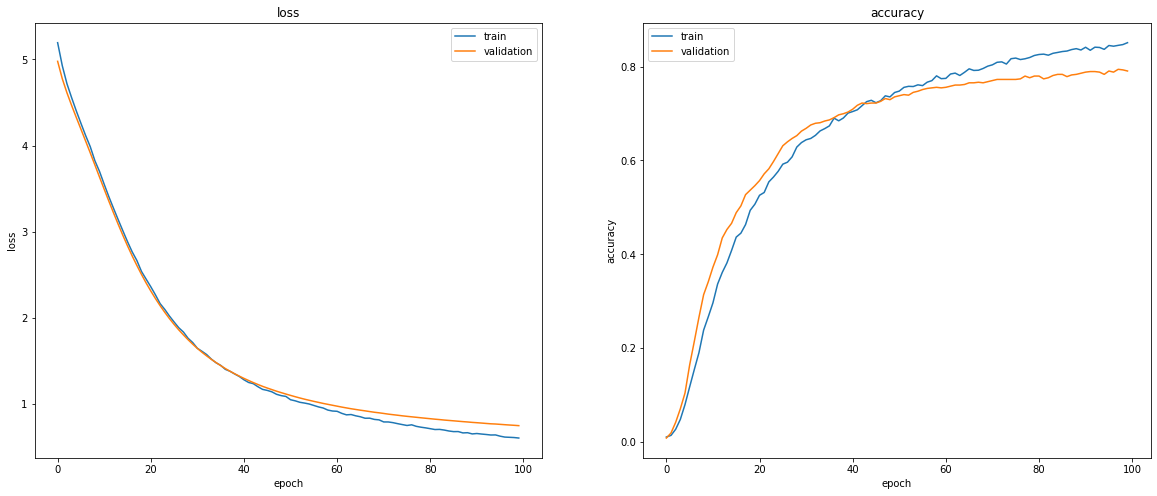

Wall time: 354 ms


In [39]:
%time display_model_acc_loss(resnet50_history)

In [40]:
### TODO: Load the model weights with the best validation loss.
res50net_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [41]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
resnet50_predictions = [np.argmax(res50net_model.predict(np.expand_dims(feature, axis=0))) for feature in test_res50net]

# report test accuracy
test_accuracy = 100*np.sum(np.array(resnet50_predictions) == np.argmax(test_targets, axis=1))/len(resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Test accuracy: 79.5455%


In [42]:
### TODO: Write a function that takes a path to an image as input and returns the dog breed that is predicted by the model.
def ResNet50_predict_breed(img_path):
    
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))

    # obtain predicted vector
    predicted_vector = res50net_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

1/1 [==============================] - 0s 21ms/step


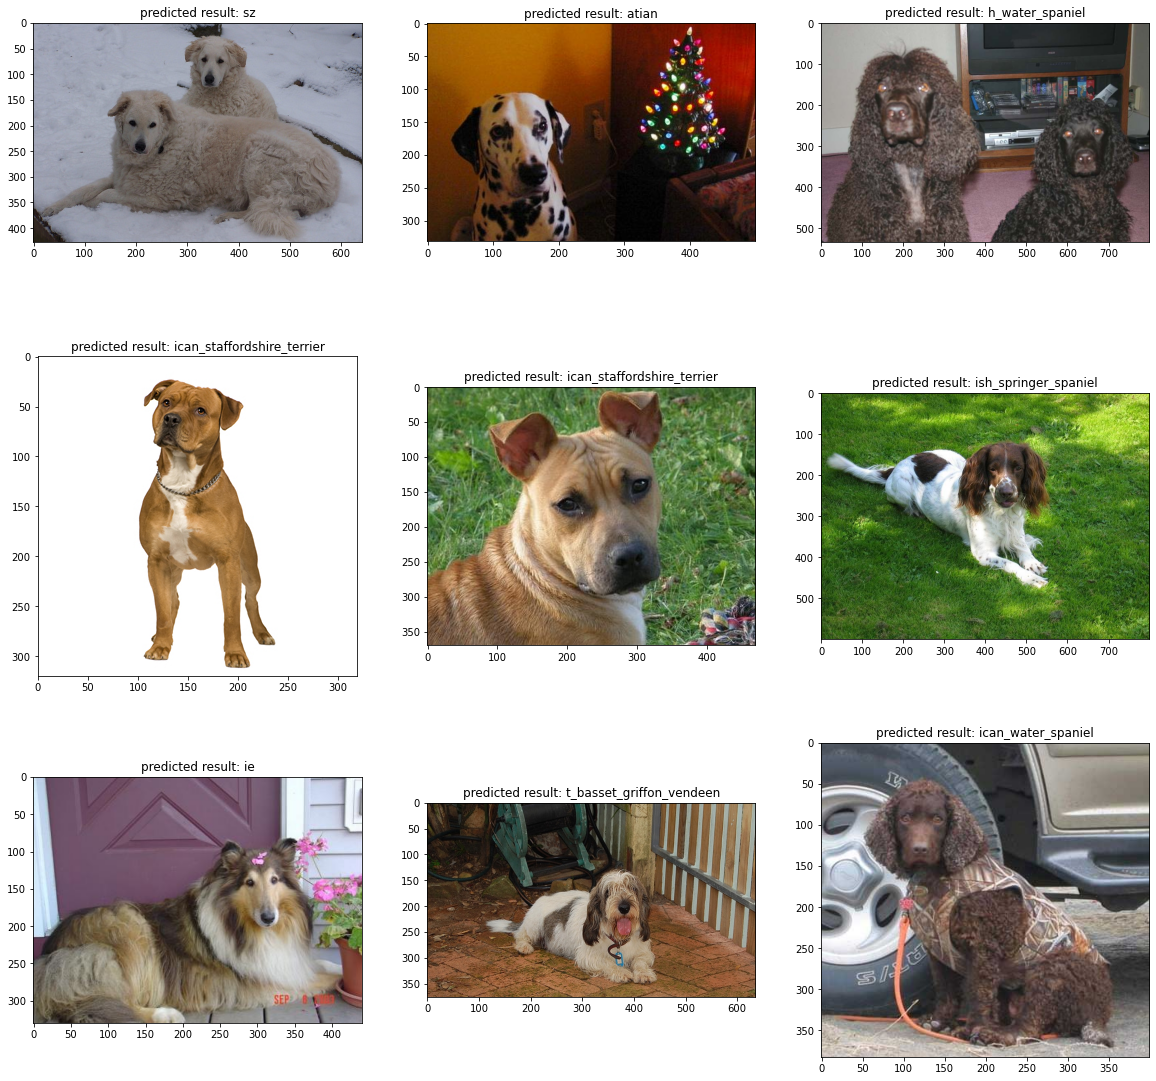

In [43]:
image_paths = dog_files_short[:9]

fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (20, 20))
ax = ax.ravel()

for k in range(9):
    images = cv2.imread(image_paths[k])
    img_rgb = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    ax[k].imshow(img_rgb)
    dog_breed = ResNet50_predict_breed(image_paths[k]).replace('ages/train/', '')[4:]
    ax[k].set_title('predicted result: ' + dog_breed)

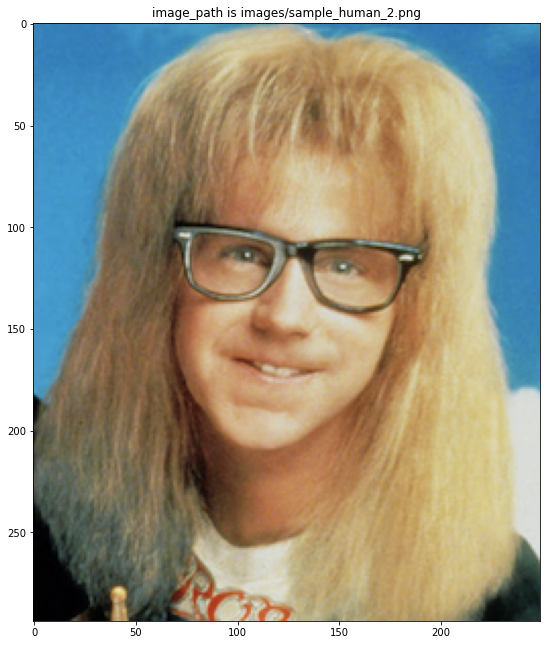

1/1 [==============================] - 0s 118ms/step
Human detector: True
If this one were a dog, he / she would be a ... Pomeranian!!


In [44]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def predict_breed(img_path, img_width = 10):
    """
        Description: This function is used to determine whether the image contains a human, dog, both or neither
        
        Input
            img_path : path to the image
            img_width (int): width of the displayed image belong, default = 10
            
        Output
            show the image and the comment of detection result
    """
    
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ratio = img.shape[0] / img.shape[1]
    fig, ax = plt.subplots(1, 1, figsize = (img_width, int(img_width*ratio)))
    ax.imshow(cv_rgb)
    ax.set_title('image_path is {}'.format(img_path))
    plt.show()
    
    breed = ResNet50_predict_breed(img_path).replace('ages/train/', '')[:]
    
    if dog_detector(img_path) & (face_detector(img_path) == 0):
        print("Dog detector: True")
        return print("This dog breed can be a {}".format(breed))
        
    elif face_detector(img_path) & (dog_detector(img_path) == 0):
        print("Human detector: True")
        return print("If this one were a dog, he / she would be a ... {}!!".format(breed))
    
    elif face_detector(img_path) & (dog_detector(img_path) == 1):
        print("Dog and human were detected in this image")
        return print("If this one were a dog, he / she would be a ... {}!!".format(breed))
        
    else:
        return print("Oopss... The algoritm must be improved or 'No human or dog has been detected in this image'.")
    
predict_breed('images/sample_human_2.png')

In [45]:
## TODO: Execute your algorithm from Step 6 on at least 6 images on your computer.
## Feel free to use as many code cells as needed.
image_list = os.listdir('images')
image_list = [img for img in image_list if img not in ['ipynb_checkpoints', '.ipynb_checkpoints',
                                                       'sample_cnn.png', 'sample_human_2.png']]
image_list = sorted(image_list)
print(image_list)
len(image_list)

['American_water_spaniel_00648.jpg', 'Brittany_02625.jpg', 'Curly-coated_retriever_03896.jpg', 'Labrador_retriever_06449.jpg', 'Labrador_retriever_06455.jpg', 'Labrador_retriever_06457.jpg', 'README.md', 'Welsh_springer_spaniel_08203.jpg', 'dog_1.png', 'human_dog.jpg', 'human_dog_1', 'human_dog_2', 'mess_app_dog.jpg', 'mess_app_dog_2.jpg', 'sample_dog_output.png', 'xijingdog.jpg']


16

- **Pic 1.**

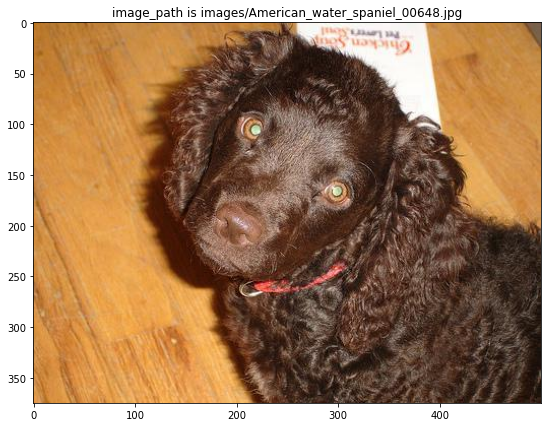

1/1 [==============================] - 0s 197ms/step
Dog detector: True
This dog breed can be a Irish_water_spaniel


In [46]:
image_path = 'images/' + image_list[0]
predict_breed(image_path)

- **Pic 2.**

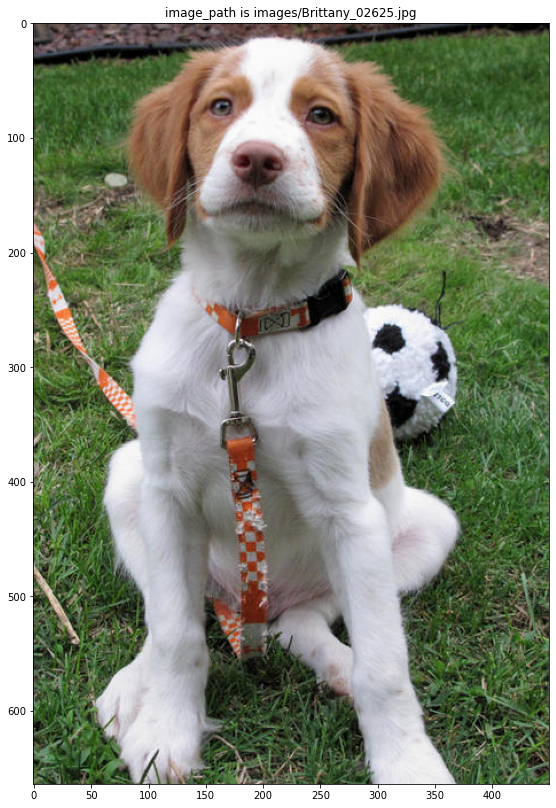

1/1 [==============================] - 0s 154ms/step
Dog and human were detected in this image
If this one were a dog, he / she would be a ... Brittany!!


In [47]:
image_path = 'images/' + image_list[1]
predict_breed(image_path)

=> **Cons 1.** In this case, the only the dog was in the picture but my algorithm has detected the human and dog! This may be I has use the function `face_detector` instead of `face_detector2`-which will better the first one.

- **Pic 3.**

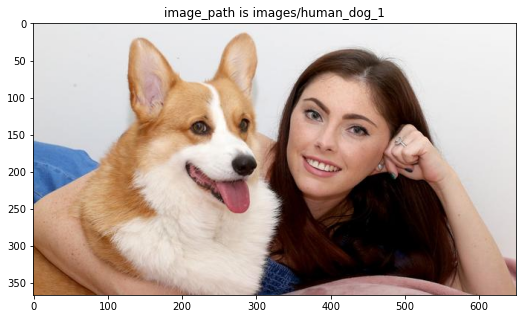

1/1 [==============================] - 0s 99ms/step
Dog and human were detected in this image
If this one were a dog, he / she would be a ... Pembroke_welsh_corgi!!


In [48]:
image_path = 'images/' + image_list[10]
predict_breed(image_path)

=> **Cons 2.** In this case, the woman and her dog can not be detected. Because the algoritm can not work well if the faces is not `frontal face`, I think.

- **Pic 4.**

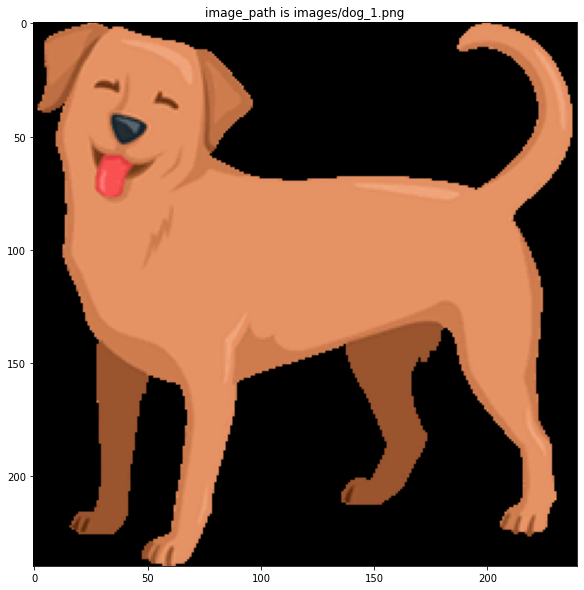

C:\Users\admin\anaconda3\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 0s 137ms/step
Dog detector: True
This dog breed can be a Canaan_dog


In [49]:
image_path = 'images/' + image_list[8]
predict_breed(image_path)

- **Pic 5.**

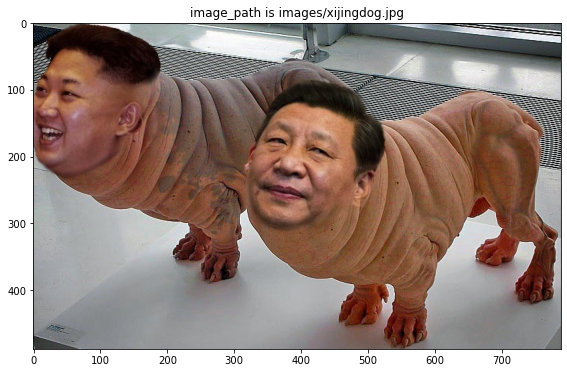

1/1 [==============================] - 0s 195ms/step
Human detector: True
If this one were a dog, he / she would be a ... Brussels_griffon!!


In [50]:
image_path = 'images/' + image_list[-1]
predict_breed(image_path)

- **Pic 6.**

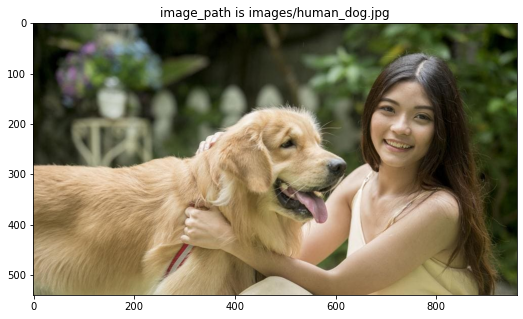

1/1 [==============================] - 0s 132ms/step
Dog and human were detected in this image
If this one were a dog, he / she would be a ... English_cocker_spaniel!!


In [51]:
image_path = 'images/' + image_list[9]
predict_breed(image_path)

- **Pic 7.**

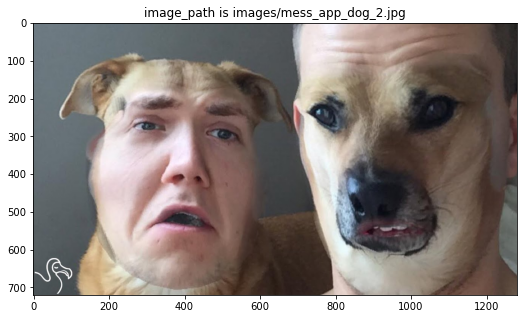

1/1 [==============================] - 0s 107ms/step
Dog and human were detected in this image
If this one were a dog, he / she would be a ... Anatolian_shepherd_dog!!


In [52]:
image_path = 'images/' + image_list[13]
predict_breed(image_path)

- **Pic 8.**

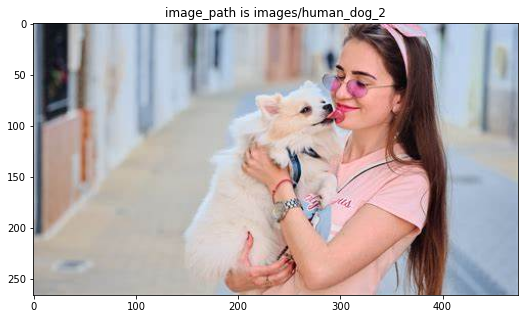

1/1 [==============================] - 0s 130ms/step
Oopss... The algoritm must be improved or 'No human or dog has been detected in this image'.


In [53]:
image_path = 'images/' + image_list[11]
predict_breed(image_path)

- **Pic 9.**

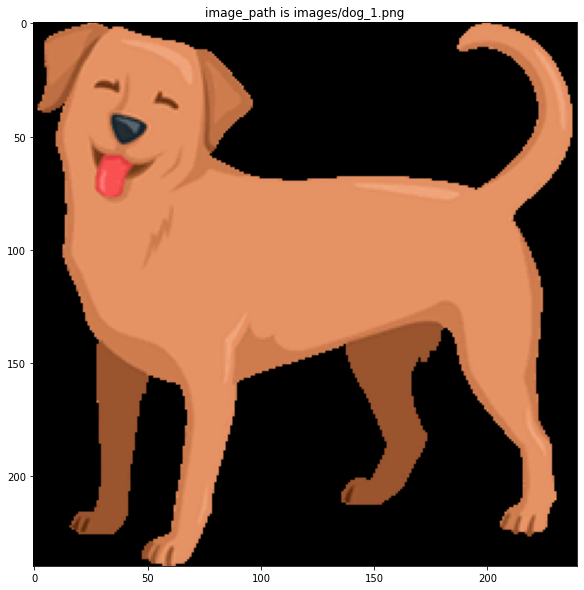

1/1 [==============================] - 0s 145ms/step
Dog detector: True
This dog breed can be a Canaan_dog


In [54]:
image_path = 'images/dog_1.png'
predict_breed(image_path)

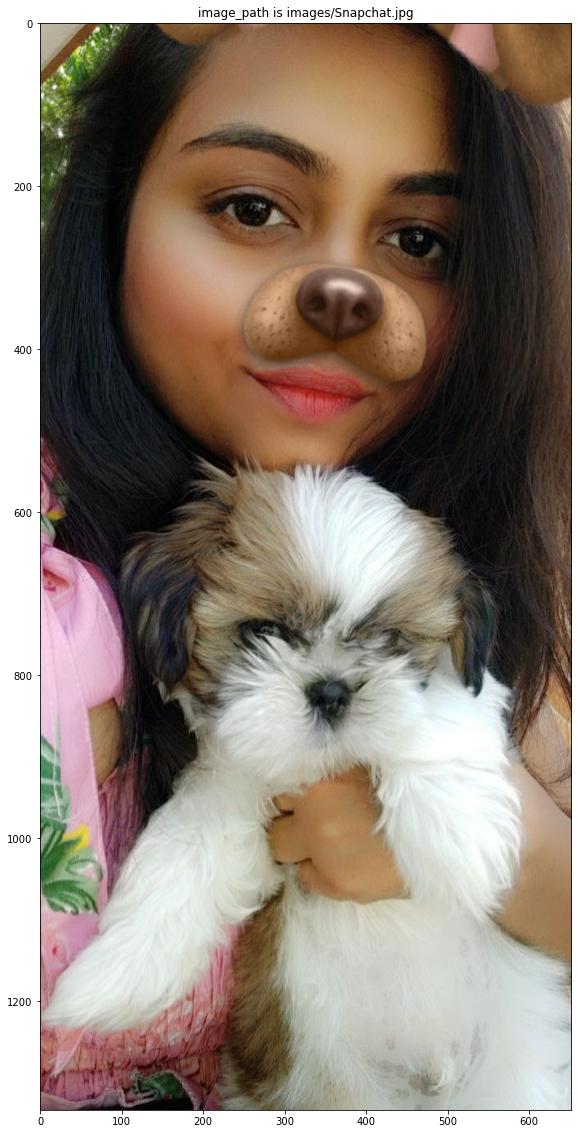

1/1 [==============================] - 0s 106ms/step
Dog and human were detected in this image
If this one were a dog, he / she would be a ... Chinese_crested!!


In [57]:
image_path = 'images/Snapchat.jpg'
predict_breed(image_path)